In [1]:
import numpy as np
import pandas as pd

crsp = pd.read_csv("CRSP.csv")

/tmp/ipykernel_12055/3857759870.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp = pd.read_csv("CRSP.csv")


In [2]:
crsp["RET"] = crsp["RET"].replace("C", np.nan).replace("B", np.nan).astype(float)
crsp = crsp.dropna(subset=["TICKER", "PRC"])

crsp["VOL"] = crsp["VOL"].fillna(0)
crsp["DVOL"] = crsp["VOL"] * crsp["PRC"]
crsp["MarketCap"] = crsp["PRC"].abs()  * crsp["SHROUT"] * (crsp["CFACSHR"] / crsp["CFACPR"])

crsp = crsp.loc[
    (crsp["SHRCD"].isin([10, 11, 12]))
]


In [3]:
rets = pd.pivot_table(
    crsp,
    values="RET",
    index="date",
    columns="PERMNO"
)
companies = crsp[crsp.date == "2000-01-03"].nlargest(500, "MarketCap").PERMNO

rets = rets[companies]

vol60 = rets.ewm(60).std() * np.sqrt(252) + 0.01

In [4]:
train = rets.loc[:"2010-01-01"].dropna(axis=1)
test = rets.loc["2010-01-01":]
vol60 = vol60[train.columns].iloc[60:]
train = train.iloc[60:]

test = test[train.columns]

In [5]:
from core.contional_estimator import DCCEstimator
from core.unconditional_estimator import SampleCov, QIS, LS, AO



C_qis = QIS(train.values, vol60.reindex_like(train).values).estimate()
C_ls_3 = LS(train.values, vol60.reindex_like(train).values, rho=0.3).estimate()


In [6]:

S_total = train.values / vol60.reindex_like(train).values
C_ao_100 = AO(train.values, vol60.reindex_like(train).values, 
              lookback_window=500,).fit(S_total, sampling=10).estimate()

Fitting AO model...: 100%|██████████| 196/196 [00:14<00:00, 13.70it/s]


In [7]:
vol_test = vol60.reindex(test.index)
vol_test = vol_test.dropna()

test_aligned = test.reindex(vol_test.index)

vol_test = vol_test.clip(lower=1e-6)

(test_aligned.shape, vol_test.shape)

((3774, 312), (3774, 312))

In [26]:
import numpy as np
import pandas as pd
from tqdm import tqdm


def run_dcc_gmv_backtest(
    C_prior: np.ndarray,
    returns_df: pd.DataFrame,
    vol_df: pd.DataFrame,
    alpha: float = 0.01,
    beta: float = 0.98,
    ridge: float = 1e-6,
    annualization: int = 252,
    long_only: bool = False,
):
    """Run a DCC one-step update backtest and return GMV performance stats."""
    clean_returns = returns_df.fillna(0.0)
    estimator = DCCEstimator(C_prior, clean_returns.values, vol_df.values, alpha=alpha, beta=beta)
    estimator.reset()

    n_assets = C_prior.shape[0]
    portfolio_returns: list[float] = []
    turnover_series: list[float] = []
    gross_leverage_series: list[float] = []
    effective_n_series: list[float] = []
    prev_w = np.zeros(n_assets)
    has_prev_weights = False

    for i, date in enumerate(tqdm(returns_df.index)):
        estimator._step()
        D_t = np.diag(estimator.D[i])
        Sigma_t = D_t @ estimator.R_t @ D_t
        Sigma_t = 0.5 * (Sigma_t + Sigma_t.T) + np.eye(n_assets) * ridge

        returns_row = returns_df.iloc[i]
        available = returns_row.notna()
        if not np.any(available):
            portfolio_returns.append(np.nan)
            turnover_series.append(np.nan)
            gross_leverage_series.append(np.nan)
            effective_n_series.append(np.nan)
            continue

        idx = np.where(available)[0]
        Sigma_slice = Sigma_t[np.ix_(idx, idx)] + np.eye(len(idx)) * ridge
        inv_cov = np.linalg.pinv(Sigma_slice)
        ones_slice = np.ones(len(idx))
        w_slice = inv_cov @ ones_slice
        w_slice /= ones_slice @ w_slice

        if long_only:
            w_slice = np.clip(w_slice, 0.0, None)
            weight_sum = w_slice.sum()
            if weight_sum <= 0:
                w_slice = np.ones(len(idx)) / len(idx)
            else:
                w_slice /= weight_sum

        r_obs = returns_row.values[idx]
        portfolio_returns.append(float(r_obs @ w_slice))

        full_w = np.zeros(n_assets)
        full_w[idx] = w_slice
        gross_leverage_series.append(float(np.sum(np.abs(full_w))))
        weight_sq_sum = float(np.sum(full_w ** 2))
        effective_n_series.append(float(1.0 / weight_sq_sum) if weight_sq_sum > 0 else np.nan)
        if has_prev_weights:
            turnover_series.append(float(np.sum(np.abs(full_w - prev_w))))
        else:
            turnover_series.append(np.nan)
            has_prev_weights = True
        prev_w = full_w

    returns_series = pd.Series(portfolio_returns, index=returns_df.index, name="gmv_return").dropna()
    metrics = pd.DataFrame(
        {
            "turnover": turnover_series,
            "gross_leverage": gross_leverage_series,
            "effective_n_assets": effective_n_series,
        },
        index=returns_df.index,
    )
    metrics = metrics.loc[returns_series.index]

    cumulative = (1 + returns_series).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1

    stats = pd.Series(
        {
            "mean_daily": returns_series.mean(),
            "vol_daily": returns_series.std(),
            "sharpe_ann": (returns_series.mean() / returns_series.std()) * np.sqrt(annualization)
            if returns_series.std() > 0
            else np.nan,
            "cumulative_return": cumulative.iloc[-1] - 1,
            "max_drawdown": drawdown.min(),
            "turnover_sum": float(np.nanmean(metrics["turnover"].values)),
            "gross_leverage_mean": metrics["gross_leverage"].mean(),
            "effective_n_assets_mean": metrics["effective_n_assets"].mean(),
        }
    )

    return returns_series, stats, metrics

In [12]:
gmv_returns_ls, gmv_stats_ls, gmv_metrics_ls = run_dcc_gmv_backtest(
    C_ls_3,
    test_aligned,
    vol_test,
)

display(gmv_stats_ls.to_frame("value"))

gmv_returns_qis, gmv_stats_qis, gmv_metrics_qis = run_dcc_gmv_backtest(
    C_qis,
    test_aligned,
    vol_test,
)

display(gmv_stats_qis.to_frame("value"))

gmv_returns_ao, gmv_stats_ao, gmv_metrics_ao = run_dcc_gmv_backtest(
    C_ao_100,
    test_aligned,
    vol_test,
)
display(gmv_stats_ao.to_frame("value"))

100%|██████████| 3774/3774 [02:34<00:00, 24.47it/s]


,value
mean_daily,0.000159
vol_daily,0.001601
sharpe_ann,1.579359
cumulative_return,0.815285
max_drawdown,-0.038311
turnover_sum,0.270631
gross_leverage_mean,3.384960
effective_n_assets_mean,10.803934


100%|██████████| 3774/3774 [02:38<00:00, 23.79it/s]


,value
mean_daily,0.000135
vol_daily,0.001522
sharpe_ann,1.412587
cumulative_return,0.659802
max_drawdown,-0.037557
turnover_sum,0.307653
gross_leverage_mean,3.814332
effective_n_assets_mean,8.603517


100%|██████████| 3774/3774 [03:01<00:00, 20.84it/s]


,value
mean_daily,0.000086
vol_daily,0.001334
sharpe_ann,1.022869
cumulative_return,0.378452
max_drawdown,-0.031897
turnover_sum,0.497708
gross_leverage_mean,5.486436
effective_n_assets_mean,4.140736


In [21]:
agg_results = pd.DataFrame({
    "LS_0.3": gmv_stats_ls,
    "QIS": gmv_stats_qis,
    "AO_100": gmv_stats_ao,
})

# to latex
print(agg_results.T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & mean_daily & vol_daily & sharpe_ann & cumulative_return & max_drawdown & turnover_sum & gross_leverage_mean & effective_n_assets_mean \\
\midrule
LS_0.3 & 0.000159 & 0.001601 & 1.579359 & 0.815285 & -0.038311 & 0.270631 & 3.384960 & 10.803934 \\
QIS & 0.000135 & 0.001522 & 1.412587 & 0.659802 & -0.037557 & 0.307653 & 3.814332 & 8.603517 \\
AO_100 & 0.000086 & 0.001334 & 1.022869 & 0.378452 & -0.031897 & 0.497708 & 5.486436 & 4.140736 \\
\bottomrule
\end{tabular}



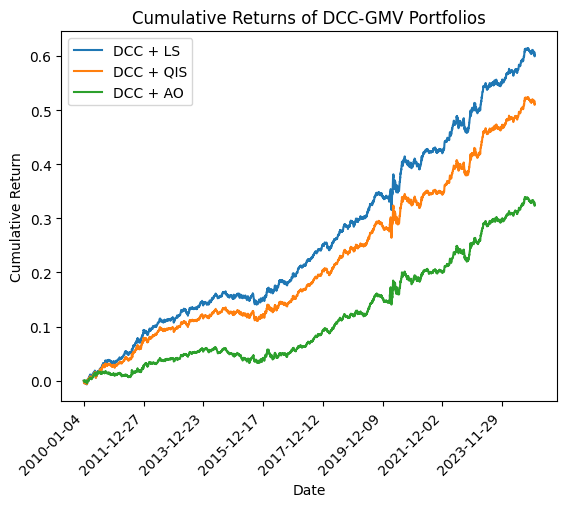

In [25]:

gmv_returns_ls.cumsum().plot(label="DCC + LS")
gmv_returns_qis.cumsum().plot(label="DCC + QIS")
gmv_returns_ao.cumsum().plot(label="DCC + AO")

import matplotlib.pyplot as plt
plt.legend()
plt.title("Cumulative Returns of DCC-GMV Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")

plt.xticks(rotation=45, ha="right")

plt.show()



In [27]:
gmv_returns_ls_lo, gmv_stats_ls_lo, gmv_metrics_ls_lo = run_dcc_gmv_backtest(
    C_ls_3,
    test_aligned,
    vol_test,
    long_only=True,
)

display(gmv_stats_ls_lo.to_frame("value"))

gmv_returns_qis_lo, gmv_stats_qis_lo, gmv_metrics_qis_lo = run_dcc_gmv_backtest(
    C_qis,
    test_aligned,
    vol_test,
    long_only=True,
)

display(gmv_stats_qis_lo.to_frame("value"))

gmv_returns_ao_lo, gmv_stats_ao_lo, gmv_metrics_ao_lo = run_dcc_gmv_backtest(
    C_ao_100,
    test_aligned,
    vol_test,
    long_only=True,
)
display(gmv_stats_ao_lo.to_frame("value"))



100%|██████████| 3774/3774 [02:01<00:00, 30.98it/s]


,value
mean_daily,0.000443
vol_daily,0.007868
sharpe_ann,0.893133
cumulative_return,3.726157
max_drawdown,-0.306446
turnover_sum,0.073167
gross_leverage_mean,1.000000
effective_n_assets_mean,64.393930


100%|██████████| 3774/3774 [01:59<00:00, 31.57it/s]


,value
mean_daily,0.000447
vol_daily,0.008109
sharpe_ann,0.875222
cumulative_return,3.771101
max_drawdown,-0.313300
turnover_sum,0.074744
gross_leverage_mean,1.000000
effective_n_assets_mean,63.405455


100%|██████████| 3774/3774 [01:54<00:00, 33.02it/s]


,value
mean_daily,0.000462
vol_daily,0.008934
sharpe_ann,0.820832
cumulative_return,3.913599
max_drawdown,-0.329578
turnover_sum,0.085871
gross_leverage_mean,1.000000
effective_n_assets_mean,62.344215


In [28]:
agg_results_lo = pd.DataFrame({
    "LS_0.3": gmv_stats_ls_lo,
    "QIS": gmv_stats_qis_lo,
    "AO_100": gmv_stats_ao_lo,
})

# to latex
print(agg_results_lo.T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & mean_daily & vol_daily & sharpe_ann & cumulative_return & max_drawdown & turnover_sum & gross_leverage_mean & effective_n_assets_mean \\
\midrule
LS_0.3 & 0.000443 & 0.007868 & 0.893133 & 3.726157 & -0.306446 & 0.073167 & 1.000000 & 64.393930 \\
QIS & 0.000447 & 0.008109 & 0.875222 & 3.771101 & -0.313300 & 0.074744 & 1.000000 & 63.405455 \\
AO_100 & 0.000462 & 0.008934 & 0.820832 & 3.913599 & -0.329578 & 0.085871 & 1.000000 & 62.344215 \\
\bottomrule
\end{tabular}



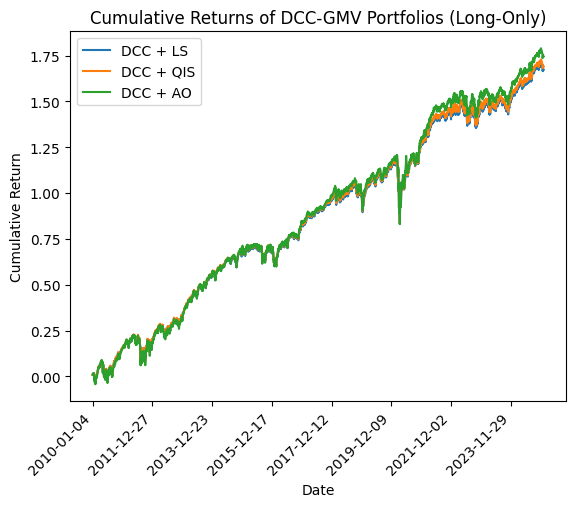

In [29]:

gmv_returns_ls_lo.cumsum().plot(label="DCC + LS")
gmv_returns_qis_lo.cumsum().plot(label="DCC + QIS")
gmv_returns_ao_lo.cumsum().plot(label="DCC + AO")

import matplotlib.pyplot as plt
plt.legend()
plt.title("Cumulative Returns of DCC-GMV Portfolios (Long-Only)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")

plt.xticks(rotation=45, ha="right")

plt.show()

